# Project 3 - Classification
Welcome to the third project of Data 8!  You will build a classifier that guesses whether a song is hip-hop or country, using only the numbers of times words appear in the song's lyrics.  By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

### Logistics


**Deadline.** This project is due at 11:59pm on Thursday 4/27. You can earn an early submission bonus point by submitting your completed project by Wednesday 4/26. Late submissions will be accepted until Tuesday 5/2, but a 10% late penalty will be applied for each day late. It's **much** better to be early than late, so start working now.

**Checkpoint.** For full credit, you must also **complete Part 1 of the project (out of 4) and submit them by 11:59pm on Friday 4/21**. You will have some lab time to work on these questions, but we recommend that you start the project before lab and leave time to finish the checkpoint afterward.

**Partners.** You may work with one other partner. It's best to work with someone in your lab. Only one of you is required to submit the project. On [okpy.org](http://okpy.org), the person who submits should also designate their partner so that both of you receive credit.

**Rules.** Don't share your code with anybody but your partner. You are welcome to discuss questions with other students, but don't share the answers. The experience of solving the problems in this project will prepare you for exams (and life). If someone asks you for the answer, resist! Instead, you can demonstrate how you would solve a similar problem.

**Support.** You are not alone! Come to office hours, post on Piazza, and talk to your classmates. If you want to ask about the details of your solution to a problem, make a private Piazza post and the staff will respond. If you're ever feeling overwhelmed or don't know how to make progress, email your TA or tutor for help. You can find contact information for the staff on the [course website](http://data8.org/sp17/staff.html).

**Tests.** Passing the tests for a question **does not** mean that you answered the question correctly. Tests usually only check that your table has the correct column labels. However, more tests will be applied to verify the correctness of your submission in order to assign your final score, so be careful and check your work!

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect. You can add any additional names or functions you want to the provided cells. 

To get started, load `datascience`, `numpy`, `plots`, and `ok`.

In [1]:
# Run this cell to set up the notebook, but please don't change it.

import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('project3.ok')
_ = ok.auth(inline=True)

Assignment: Project 3 - Classification
OK, version v1.9.5

Successfully logged in as stiwari@berkeley.edu


# 1. The Dataset

Our dataset is a table of songs, each with a name, an artist, and a genre.  We'll be trying to predict each song's genre.

The only attributes we will use to predict the genre of a song are its lyrics. In particular, we have a list of just under 5,000 words that might occur in a song.  For each song, our dataset tells us the frequency with which each of these words occurs in that song. All words have been converted to lowercase.

Run the cell below to read the `lyrics` table. **It may take up to a minute to load.**

In [2]:
lyrics = Table.read_table('lyrics.csv')
lyrics.where("Title", "In Your Eyes").select(0, 1, 2, 3, 4, 5, "like", "love")

Title,Artist,Genre,i,the,you,like,love
In Your Eyes,Alison Krauss,Country,0.107143,0,0.0297619,0.0119048,0.0595238


That cell prints a few columns of the row for the country song ["In Your Eyes" by Alison Krauss](http://www.azlyrics.com/lyrics/alisonkrauss/inyoureyes.html).  The song contains 168 words. The word "like" appears twice:  $\frac{2}{168} \approx 0.0119$ of the words in the song. The word "love" appears 10 times: $\frac{10}{168} \approx 0.0595$ of the words. The word "the" doesn't appear at all.

Our dataset doesn't contain all information about a song.  For example, it doesn't describe the order of words in the song, let alone the melody, instruments, or rhythm. Nonetheless, you may find that word frequencies alone are sufficient to build an accurate genre classifier.

All titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [3]:
title_index = lyrics.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    lyrics.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

For example, the fastest way to find the frequency of "love" in the song *In Your Eyes* is to access the `'love'` item from its row.

In [4]:
row_for_title('In Your Eyes').item('love')

0.059523810000000003

#### Question 1.1
Set `expected_row_sum` to the number that you expect will result from summing all proportions in each row, excluding the first three columns.

In [5]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 0.15

In [6]:
_ = ok.grade("q1_1")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Run the cell below to generate a histogram of the actual row sums. It should confirm your answer above, perhaps with a small amount of error.

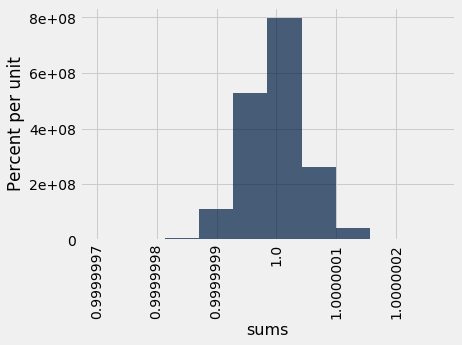

In [7]:
# Run this cell to display a histogram of the sums of proportions in each row.
# This computation might take up to a minute; you can skip it if it's too slow.
Table().with_column('sums', lyrics.drop([0, 1, 2]).apply(sum)).hist(0)

This dataset was extracted from the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/). Specifically, we are using the complementary datasets from [musiXmatch](http://labrosa.ee.columbia.edu/millionsong/musixmatch) and [Last.fm](http://labrosa.ee.columbia.edu/millionsong/lastfm). 

The counts of common words in the lyrics for all of these songs are provided by the musiXmatch dataset (called a bag-of-words format). We converted the words to lowercase, removed the naughty ones, and converted the counts to frequencies.

The Last.fm dataset contains multiple tags for each song in the Million Song Dataset. Some of the tags are genre-related, such as "pop", "rock", "classic", etc.  To construct the `Genre` column, we first extracted songs with Last.fm tags that included the words "country", or both "hip" and "hop". These songs were then cross-referenced with the musiXmatch dataset, and only songs with musixMatch lyrics were placed into our dataset. 

In [8]:
print('Words with frequencies:', lyrics.drop('Title', 'Artist', 'Genre').num_columns)
print('Songs with genres:', lyrics.num_rows)

Words with frequencies: 4817
Songs with genres: 1721


## 1.1. Word Stemming
The columns other than Title, Artist, and Genre in the `lyrics` table are all words that appear in some of the songs in our dataset.  Some of those names have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each song.  

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [9]:
# Just run this cell.
vocab_mapping = Table.read_table('mxm_reverse_mapping_safe.csv')
stemmed = np.take(lyrics.labels, np.arange(3, len(lyrics.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
devant,devant
devast,devastation
devil,devil
devot,devotion
devour,devour
dew,dew
di,di
dia,dia
diablo,diablo
dial,dial


#### Question 1.1.1
Assign `unchanged` to the **percentage** of words in `vocab_table` that are the same as their stemmed form (such as "devour" above).

*Hint:* Try using `where` and comparing the number of rows in a table of only unchanged vocabulary with the number of rows in `vocab_table`.

In [10]:
count = 0
for i in np.arange(vocab_table.num_rows):
    if len(vocab_table.column(0).item(i)) == len(vocab_table.column(1).item(i)):
        count += 1
percent_unchanged = count * 100 / vocab_table.num_rows
percent_unchanged
print(round(percent_unchanged, 2), 'percent are unchanged')

75.4 percent are unchanged


In [11]:
_ = ok.grade("q1_1_1")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.1.2
Assign `stemmed_message` to the stemmed version of the word "message".

In [12]:
# Set stemmed_message to the stemmed version of "message" (which
# should be a string).  Use vocab_table.
stemmed_message = vocab_table.where('Word', are.equal_to('message')).column('Stem')[0]
stemmed_message

'messag'

In [13]:
_ = ok.grade("q1_1_2")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.1.3
Assign `unstemmed_singl` to the word in `vocab_table` that has "singl" as its stemmed form. (*Note that multiple English words may stem to "singl", but only one example appears in `vocab_table`.*)

In [14]:
# Set unstemmed_singl to the unstemmed version of "singl" (which
# should be a string).
unstemmed_singl = vocab_table.where('Stem', are.equal_to('singl')).column('Word')[0]
unstemmed_singl

'single'

In [15]:
_ = ok.grade("q1_1_3")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.1.4
What word in `vocab_table` was shortened the most by this stemming process? Assign `most_shortened` to the word. It's an example of how heuristic stemming can collapse two unrelated words into the same stem (which is bad, but happens a lot in practice anyway).

In [16]:
# In our solution, we found it useful to first make an array
# called shortened containing the number of characters that was
# chopped off of each word in vocab_table, but you don't have
# to do that.
shortened = []
for i in np.arange(vocab_table.num_rows):
    shortened.append(len(str(vocab_table.column(1).item(i))) - len(str(vocab_table.column(0).item(i))))
most_shortened = vocab_table.column('Word').item(shortened.index(7.0))
most_shortened
# This will display your answer and its shortened form.
vocab_table.where('Word', most_shortened)

Stem,Word
intern,international


In [17]:
_ = ok.grade("q1_1_4")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 1.2. Splitting the dataset
We're going to use our `lyrics` dataset for two purposes.

1. First, we want to *train* song genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no songs that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [18]:
# Here we have defined the proportion of our data
# that we want to designate for training as 11/16ths
# of our total dataset.  5/16ths of the data is
# reserved for testing.

training_proportion = 11/16

num_songs = lyrics.num_rows
num_train = int(num_songs * training_proportion)
num_valid = num_songs - num_train

train_lyrics = lyrics.take(np.arange(num_train))
test_lyrics = lyrics.take(np.arange(num_train, num_songs))

print("Training: ",   train_lyrics.num_rows, ";",
      "Test: ",       test_lyrics.num_rows)

Training:  1183 ; Test:  538


#### Question 1.2.1
Draw a horizontal bar chart with two bars that show the proportion of Country songs in each dataset.  Complete the function `country_proportion` first; it should help you create the bar chart.

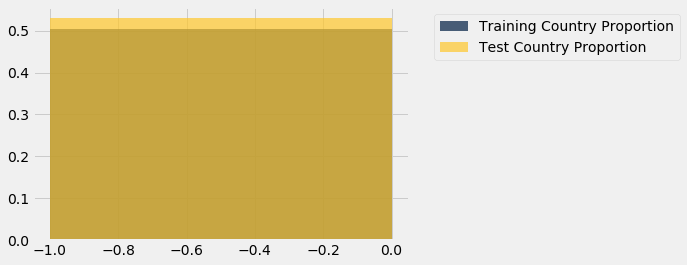

In [25]:
def country_proportion(table):
    """Return the proportion of songs in a table that have the Country genre."""
    return table.where('Genre', are.equal_to('Country')).num_rows / table.num_rows

# The staff solution took 4 lines.  Start by creating a table.
Table().with_columns(
'Training Country Proportion', country_proportion(train_lyrics),
'Test Country Proportion', country_proportion(test_lyrics)).bar()

### Checkpoint Reached

You have reached the project checkpoint. Please submit now in order to record your progress. If you go back and revise your answers in the section above after the checkpoint is due, that's ok. Your revised answers will be graded. However, you will only get credit for your checkpoint submission if you have passed the tests provided for every question above.

If you are working with a partner, only one of you needs to submit. For both of you to receive credit, the person who submits must invite the other to be their partner on [okpy.org](http://okpy.org). Please invite your partner now and tell them to accept the invitation **before** the checkpoint deadline!

In [20]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'project3.ipynb'.
Submit... 100% complete
Submission successful for user: stiwari@berkeley.edu
URL: https://okpy.org/cal/data8/sp17/project3/submissions/OY6nnL



# 2. K-Nearest Neighbors - a Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each song is *the proportion of times a particular word appears in the lyrics*, and the labels are two music genres: hip-hop and country.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_lyrics` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a  song

In k-NN, we classify a song by finding the `k` songs in the *training set* that are most similar according to the features we choose. We call those songs with similar features the *nearest neighbors*.  The k-NN algorithm assigns the song to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each song.  The features we will use are the proportions of the words "like" and "love" in the lyrics.  Taking the song "In Your Eyes" (in the test set), 0.0119 of its words are "like" and 0.0595 are "love". This song appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two songs is the straight-line distance between them when we plot their features in a scatter diagram. This distance is called the Euclidean ("yoo-KLID-ee-un") distance.  

For example, in the song *Insane in the Brain* (in the training set), 0.0203 of all the words in the song are "like" and 0 are "love".  Its distance from *In Your Eyes* on this 2-word feature set is $\sqrt{(0.0119 - 0.0203)^2 + (0.0595 - 0)^2} \approx 0.06$.  (If we included more or different features, the distance could be different.)

A third song, *Sangria Wine* (in the training set), is 0.0044 "like" and 0.0925 "love".

The function below creates a plot to display the "like" and "love" features of a test song and some training songs. As you can see in the result, *In Your Eyes* is more similar to *Sangria Wine* than to *Insane in the Brain*.

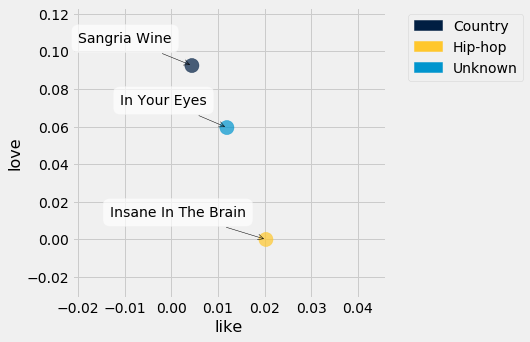

In [26]:
# Just run this cell.

def plot_with_two_features(test_song, training_songs, x_feature, y_feature):
    """Plot a test song and training songs using two features."""
    test_row = row_for_title(test_song)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['Unknown'],
            'Title',   [test_song]
        )
    for song in training_songs:
        row = row_for_title(song)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), song])
    distances.scatter(x_feature, y_feature, colors='Color', labels='Title', s=200)
    
training = ["Sangria Wine", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

#### Question 2.1.1
Compute the distance between the two country songs, *In Your Eyes* and *Sangria Wine*, using the `like` and `love` features only.  Assign it the name `country_distance`.

**Note:** If you have a row object, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

**Note 2:** You can quickly get the row from the `lyrics` table via `row_for_title`. For example, if "Insane In The Brain" is the song title, then `row_for_title("Insane In The Brain")` is the row object for this song.

In [27]:
in_your_eyes = row_for_title("In Your Eyes")
sangria_wine = row_for_title("Sangria Wine")
country_distance = (((in_your_eyes.item('like') - sangria_wine.item('like')) ** 2) + ((in_your_eyes.item('love') - sangria_wine.item('love')) ** 2)) ** 0.5
country_distance

0.033828944324596891

In [28]:
_ = ok.grade("q2_1_1")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



The `plot_with_two_features` function can show the positions of several training songs. Below, we've added one that's even closer to *In Your Eyes*.

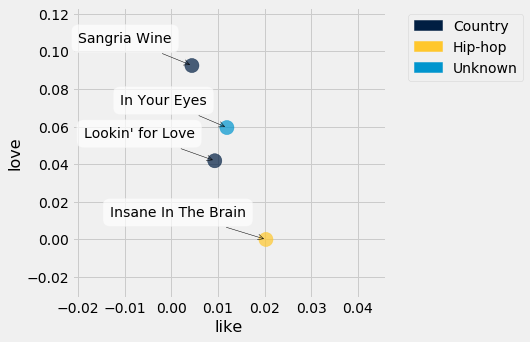

In [29]:
training = ["Sangria Wine", "Lookin' for Love", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

#### Question 2.1.2
Complete the function `distance_two_features` that computes the Euclidean distance between any two songs, using two features. The last two lines call your function to show that *Lookin' for Love* is closer to *In Your Eyes* than *Insane In The Brain*. 

In [30]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two songs with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    return ((row0.item(x_feature) - row1.item(x_feature)) ** 2 + (row0.item(y_feature) - row1.item(y_feature)) ** 2) ** 0.5

for song in make_array("Lookin' for Love", "Insane In The Brain"):
    song_distance = distance_two_features(song, "In Your Eyes", "like", "love")
    print(song, 'distance:\t', song_distance)

Lookin' for Love distance:	 0.0178540259516
Insane In The Brain distance:	 0.0601087823407


In [31]:
_ = ok.grade("q2_1_2")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.3
Define the function `distance_from_in_your_eyes` so that it works as described in its documentation.

In [32]:
def distance_from_in_your_eyes(title):
    """The distance between the given song and "In Your Eyes", based on the features "like" and "love".
    
    This function takes a single argument:
      title: A string, the name of a song.
    """
    return distance_two_features("In Your Eyes", title, "like", "love")

In [33]:
_ = ok.grade("q2_1_3")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.4
Using the features `"like" and "love"`, what are the names and genres of the 7 songs in the **training set** closest to "In Your Eyes"?  To answer this question, make a table named `close_songs` containing those 7 songs with columns `"Title"`, `"Artist"`, `"Genre"`, `"like"`, and `"love"`, as well as a column called `"distance"` that contains the distance from "In Your Eyes".  The table should be **sorted in ascending order by `distance`**.

In [34]:
# The staff solution took 4 lines.
distance = make_array()
for i in train_lyrics.column("Title"):
    song_dist = distance_from_in_your_eyes(i)
    distance = np.append(distance, song_dist)
close_songs = train_lyrics.with_column('distance', distance).select("Title", "Artist", "Genre", "like", "love", "distance").where("Title", are.not_equal_to("In Your Eyes")).sort('distance').take(np.arange(7))
close_songs

Title,Artist,Genre,like,love,distance
If This Isn't Love,Jennifer Hudson,Hip-hop,0.00886918,0.0532151,0.00700106
Big Red Rocket Of Love,Reverend Horton Heat,Hip-hop,0,0.0576923,0.0120448
In the Middle of a Heartache,Wanda Jackson,Country,0,0.0639535,0.0127022
The Hardest Part,Allison Moorer,Country,0,0.0642857,0.0128218
One Time,Justin Bieber,Hip-hop,0,0.0530303,0.0135606
This Tornado Loves You,Neko Case,Country,0,0.0528455,0.01365
You Can Have Her,Jim Ed Brown & The Browns,Country,0,0.0521327,0.0140126


In [35]:
_ = ok.grade("q2_1_4")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.1.5
Define the function `most_common` so that it works as described in its documentation below.

In [36]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    counts = make_array()
    for i in table.column(label):
        count = np.count_nonzero(table.column(label) == i)
        counts = np.append(counts, count)
    with_counts = table.with_column("Counts", counts).sort("Counts", descending=True).column(label).item(0)
    return with_counts

# Calling most_common on your table of 7 nearest neighbors classifies
# "In Your Eyes" as a country song, 4 votes to 3.
most_common('Genre', close_songs)

'Country'

In [37]:
_ = ok.grade("q2_1_5")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Congratulations are in order -- you've classified your first song!

# 3. Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two songs, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

#### Question 3.1
Write a function to compute the Euclidean distance between two *arrays* of features of *arbitrary* (but equal) length.  Use it to compute the distance between the first song in the training set and the first song in the test set, *using all of the features*.  (Remember that the title, artist, and genre of the songs are not features.)

In [38]:
def distance(features1, features2):
    """The Euclidean distance between two arrays of feature values."""
    return (sum((features1 - features2) ** 2)) ** 0.5

distance_first_to_first = distance(np.array(train_lyrics.drop("Title", "Genre", "Artist").row(0)), np.array(test_lyrics.drop("Title", "Genre", "Artist").row(0)))
distance_first_to_first

0.14822770081404466

In [39]:
_ = ok.grade("q3_1")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last question!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or more broadly *feature engineering*.

#### Question 3.1.1
Look through the list of features (the labels of the `lyrics` table after the first three).  Choose 20 common words that you think might let you distinguish between country and hip-hop songs. Make sure to choose words that are frequent enough that every song contains at least one of them. Don't just choose the 20 most frequent, though... you can do much better.

You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier.  The first time you answer this question, spend some time looking through the features, but not more than 15 minutes.

In [40]:
# Set my_20_features to an array of 20 features (strings that are column labels)
# my_20_features = make_array("like", "love", "in", "am", "your", "are", "no", "be", "with", "what", "want", "out", "got", "he", "who", "from", "off", "watch", "never", "let")
my_20_features = make_array("in", "your", "be", "with", "what", "like", "out", "get", "got", "never", "from", "he", "let", "would", "back", "here", "thing", "right", "who", "two")
train_20 = train_lyrics.select(my_20_features)
test_20 = test_lyrics.select(my_20_features)
# lyrics.take(np.arange(10))

In [41]:
lyrics.take(0)

Title,Artist,Genre,i,the,you,to,and,a,me,it,not,in,my,is,of,your,that,do,on,are,we,am,will,all,for,no,be,have,love,so,know,this,but,with,what,just,when,like,now,que,time,can,come,de,there,go,up,oh,la,one,they,out,down,get,she,was,see,if,got,never,from,he,feel,want,let,make,way,say,take,would,as,ca,day,at,babi,away,life,yeah,y,back,by,her,heart,here,how,could,night,need,our,look,where,en,eye,thing,world,more,caus,gonna,die,right,been,tell,think,un,who,el,through,man,live,again,give,too,onli,te,tri,tu,or,whi,se,keep,dream,well,mind,an,wo,still,us,his,long,mi,girl,wanna,find,fall,around,good,about,some,over,littl,turn,hand,then,noth,light,said,call,everi,alway,were,did,into,e,wait,leav,home,had,hold,run,es,walk,ever,them,lie,face,end,hear,gone,head,believ,everyth,ya,has,cri,alon,yo,hey,their,le,someth,si,insid,du,befor,o,word,stay,place,much,chang,ich,god,stand,these,better,last,friend,soul,anoth,je,left,new,him,than,stop,tonight,burn,sun,off,por,lo,play,thought,sing,show,lost,peopl,made,break,und,start,should,realli,chorus,hard,sky,old,da,even,boy,pleas,song,care,without,hope,watch,pain,amor,move,wrong,put,free,gotta,name,et,same,blue,con,danc,talk,seem,own,mine,dark,na,far,tear,true,fire,use,dead,bring,other,sin,someon,myself,forev,close,sleep,rain,those,must,una,les,sweet,mean,fight,rememb,star,while,kiss,kill,high,breath,doe,yes,al,wish,che,real,smile,two,cold,lord,year,open,il,fear,di,done,side,fli,black,line,rock,blood,lose,found,onc,non,door,bad,ooh,wonder,ti,como,enough,para,sound,togeth,mayb,los,help,shine,mani,heaven,becaus,work,touch,behind,yourself,today,big,might,death,hate,miss,ride,street,came,ask,hide,everybodi,save,till,may,beauti,roll,sure,deep,arm,son,wind,bodi,forget,happi,understand,ai,best,ma,town,war,ah,listen,seen,der,sometim,lone,hell,morn,until,set,hurt,told,first,knew,goe,round,em,alright,music,sea,truth,qui,beat,nicht,eu,las,todo,pass,under,del,late,after,ani,ground,fool,pas,broken,goodby,das,des,kind,wall,angel,est,road,reason,dan,money,chanc,quiero,mai,part,matter,learn,els,rise,pour,saw,grow,ha,sit,land,fade,air,took,nobodi,ne,fill,easi,game,follow,wake,anyth,aliv,solo,water,heard,though,white,vida,ist,voic,woman,blind,each,citi,young,lay,moon,reach,readi,fine,soon,along,à,crazi,past,red,room,such,ein,step,scream,tomorrow,control,memori,strong,hit,everyon,wast,não,men,earth,s,upon,final,shake,im,abov,ja,moment,rest,guess,hous,born,somebodi,feet,mas,sad,laugh,esta,happen,went,cest,blow,noch,meet,whole,lover,drive,car,lead,su,veri,ni,promis,bed,apart,um,empti,shadow,full,begin,pull,child,pretti,drink,pray,king,cut,t,power,gave,hay,peac,hang,next,ser,mother,é,cuando,between,pay,carri,tire,speak,lot,tree,den,skin,tout,til,slow,sinc,anymor,kid,clear,mich,jesus,differ,fast,becom,va,gun,nos,zu,más,river,faith,floor,cross,ladi,near,fun,ring,answer,pero,afraid,jag,repeat,great,stori,yet,cannot,hot,wir,nada,hour,summer,stone,bleed,sign,mir,lyric,children,trust,wild,felt,troubl,honey,sick,perfect,human,bright,bien,mama,dich,parti,train,plan,porqu,sorri,plus,hair,secret,silenc,tast,brother,throw,within,per,push,m,somewher,three,cloud,shall,vez,low,window,knee,lip,futur,dear,search,2,sie,drop,det,cool,flame,outsid,worri,bout,goin,met,stare,sight,most,mon,voy,across,wear,wave,tus,pick,er,send,siempr,wie,bone,flow,piec,soy,uh,thank,mis,straight,blame,catch,au,ce,tight,&,mile,holi,darl,auf,mouth,christma,which,moi,against,mad,both,share,caught,father,read,warm,wing,nunca,belong,damn,eat,win,sens,comm,u,fell,evil,dem,ho,pictur,second,nowher,dog,rule,une,mal,mountain,joy,mit,top,tan,som,bit,cover,point,thousand,hoy,n,gold,bell,è,devil,bird,sur,quit,brain,return,build,kick,rose,babe,guy,whoa,shame,mein,space,whisper,tiempo,cos,write,dir,tengo,count,slip,ver,desir,sei,nice,weak,rais,jai,ocean,number,drown,spirit,scare,strang,ik,half,known,pretend,worth,someday,act,beyond,fair,million,finger,question,doubt,meant,smoke,comin,flesh,dawn,daddi,storm,hole,color,jump,remain,mundo,etern,nothin,buy,nur,anyon,dress,1,minut,dont

This test makes sure that you have chosen words such that at least one appears in each song. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of songs that do not contain any words from your list, then look at the words they do contain.

In [42]:
_ = ok.grade("q3_1_1")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.1.2
In two sentences or less, describe how you selected your features. 

Essentially, I looked at the first 3 hip-hop and first 3 country songs, and I chose features that had a proportion greater than 0 for a majority either hip-hop songs or majority of country songs, and a proportion of 0 for the other genre.

Next, let's classify the first song from our test set using these features.  You can examine the song by running the cells below. Do you think it will be classified correctly?

In [43]:
print("Song:")
test_lyrics.take(0).select('Title', 'Artist', 'Genre').show()
print("Features:")
test_20.take(0).show()

Song:


Title,Artist,Genre
That Kind of Love,Alison Krauss,Country


Features:


in,your,be,with,what,like,out,get,got,never,from,he,let,would,back,here,thing,right,who,two
0.005291,0,0.010582,0.005291,0.005291,0.010582,0,0.005291,0,0,0,0,0,0.005291,0,0,0,0,0.005291,0


As before, we want to look for the songs in the training set that are most alike our test song.  We will calculate the Euclidean distances from the test song (using the 20 selected features) to all songs in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to read the code in its body unless you want to.)

In [44]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_rows):
    """An array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test song (e.g., test_20.row(0)).
      train_rows: A table of features (for example, the whole
        table train_20)."""
    assert train_rows.num_columns < 50, "Make sure you're not using all the features of the lyrics table."
    counts_matrix = np.asmatrix(train_rows.columns).transpose()
    diff = np.tile(np.array(test_row), [counts_matrix.shape[0], 1]) - counts_matrix
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    return distances

#### Question 3.1.3
Use the `fast_distances` function provided above to compute the distance from the first song in the test set to all the songs in the training set, **using your set of 20 features**.  Make a new table called `genre_and_distances` with one row for each song in the training set and two columns:
* The `"Genre"` of the training song
* The `"Distance"` from the first song in the test set 

Ensure that `genre_and_distances` is **sorted in increasing order by distance to the first test song**.

In [45]:
# The staff solution took 4 lines of code.
distances = fast_distances(test_20.row(0), train_20)
genre_and_distances = Table().with_columns(
"Genre", train_lyrics.column("Genre"),
"Distance", distances).sort("Distance")
genre_and_distances

Genre,Distance
Hip-hop,0.0108077
Country,0.011642
Hip-hop,0.0127479
Country,0.0129603
Country,0.0137479
Hip-hop,0.0138345
Hip-hop,0.0138846
Country,0.0142801
Country,0.014314
Country,0.0146802


In [46]:
_ = ok.grade("q3_1_3")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.1.4
Now compute the 5-nearest neighbors classification of the first song in the test set.  That is, decide on its genre by finding the most common genre among its 5 nearest neighbors, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this song right, and that's okay.)

In [47]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = 'Country'

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first song in the test set.
my_assigned_genre_was_correct = True

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, Country, was correct.


In [48]:
_ = ok.grade("q3_1_4")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3.2. A classifier function

Now we can write a single function that encapsulates the whole process of classification.

#### Question 3.2.1
Write a function called `classify`.  It should take the following four arguments:
* A row of features for a song to classify (e.g., `test_20.row(0)`).
* A table with a column for each feature (for example, `train_20`).
* An array of classes that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'Country'` or the string `'Hip-hop'`).

In [49]:
def classify(test_row, train_rows, train_classes, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distances = Table().with_columns(
    'Genre', train_classes,
    'Distance', distances).sort('Distance')
    return most_common("Genre", genre_and_distances.take(np.arange(k)))

In [50]:
_ = ok.grade("q3_2_1")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.2.2
Assign `grandpa_genre` to the genre predicted by your classifier for the song "Grandpa Got Runned Over By A John Deere" in the test set, using **9 neighbors** and using your 20 features.

In [51]:
# The staff solution first defined a row object called grandpa_features.
grandpa_features = test_lyrics.where('Title', "Grandpa Got Runned Over By A John Deere").select(my_20_features).row(0)
grandpa_genre = classify(grandpa_features, train_20, train_lyrics.column('Genre'), 9)
grandpa_genre

'Country'

In [52]:
_ = ok.grade("q3_2_2")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

#### Question 3.2.3
Create a classification function that takes as its argument a row containing your 20 features and classifies that row using the 5-nearest neighbors algorithm with `train_20` as its training set.

In [106]:
def classify_one_argument(row):
    return classify(row, train_20, train_lyrics.column('Genre'), 5)
# When you're done, this should produce 'Hip-hop' or 'Country'.
classify_one_argument(test_20.row(0))

'Country'

In [107]:
_ = ok.grade("q3_2_3")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1.** Use `classify_one_argument` and `apply` to classify every song in the test set.  Name these guesses `test_guesses`.  **Then**, compute the proportion of correct classifications. 

In [110]:
test_guesses = make_array()
for i in np.arange(test_20.num_rows):
    guess = classify_one_argument(test_20.row(i))
    test_guesses = np.append(test_guesses, guess)
proportion_correct = np.count_nonzero(test_guesses == test_lyrics.column('Genre')) / len(test_guesses)
proportion_correct

0.6858736059479554

In [111]:
_ = ok.grade("q3_3_1")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

## 4. Extra Explorations
Now that you know how to evaluate a classifier, it's time to build a better one.

#### Question 4.1
Find a classifier with better test-set accuracy than `classify_one_argument`.  (Your new function should have the same arguments as `classify_one_argument` and return a classification.  Name it `another_classifier`.)  You can use more or different features, or you can try different values of `k`.  (Of course, you still have to use `train_lyrics` as your training set!)

In [66]:
# To start you off, here's a list of possibly-useful features:
staff_features = make_array("come", "do", "have", "heart", "make", "never", "now", "wanna", "with", "yo", "in", "your", "be", "with", "what", "like", "out", "get", "got", "never", "from", "he", "let", "would", "back", "here", "thing", "right", "who", "two")

train_staff = train_lyrics.select(staff_features)
test_staff = test_lyrics.select(staff_features)

def another_classifier(row):
    distances = fast_distances(row, train_staff)
    genre_and_distances = Table().with_columns(
    'Genre', train_lyrics.column('Genre'),
    'Distance', distances)
    return classify(row, train_staff, train_lyrics.column('Genre'), 20)
another_classifier(test_staff.row(0))

'Country'

Briefly describe what you tried to improve your classifier. As long as you put in some effort to improving your classifier and describe what you have done, you will receive full credit for this problem.

To improve the classifier, I added more features, by appending the staff features with my 20 features. Furthermore, I increased the number of neighbors that I used to compare classifications, allowing me to increase the accuracy the data I was looking at. Ultimately, I was able to increase the accuracy of my classifier by about 1 percent.

Congratulations: you're done with the required portion of the project! Time to submit.

In [ ]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ungraded and Optional: A Custom Classifier
Try to create an even better classifier. You're not restricted to using only word proportions as features.  For example, given the data, you could compute various notions of vocabulary size or estimated song length.  If you're feeling very adventurous, you could also try other classification methods, like logistic regression.  If you think you built a classifier that works well, post on Piazza and let us know.

In [ ]:
#####################
# Custom Classifier #
#####################


## Kaggle Competition

**Note:** This part is completely optional and will not contribute towards your grade in any way.

We decided to *hold out* a set of 100 songs, for which we have provided the attributes but not the genres. You can use this set to evaluate how well you classifier performs on data for which you have never seen the correct genres. Optionally, you can submit your predictions on this dataset to Kaggle to compare your classifier to others (whoever else decides to participate).

To participate, use your classifier to predict the genre of each row in the `holdout` table. Then, call ```create_competition_submission``` to generate a CSV file that you can submit to the competition!

If you want to participate in the competition, you will have to create a Kaggle account. It's easiest for the staff to determine the winners of the competition if you use your `@berkeley.edu` email when doing so, but you can also contact your GSI if you decide to use another email address. Winners may receive honor and glory, but no material benefit.

When you are ready to make a submission, go to https://inclass.kaggle.com/c/hip-hop-or-country for further instructions.

In [ ]:
holdout = Table.read_table('holdout_attributes.csv').drop('Id')
holdout.select(0, 1, 2, 3, 4).show(5)

In [ ]:
def create_competition_submission(predictions, filename='my_submission.csv'):
    """
    Create a submission CSV for the Kaggle competition.
    
    Inputs:
      predictions - list or array of your predictions (Generated as in Question 3.3.1.)
    """
    Table().with_columns('Id', np.arange(len(predictions)), 'Predictions', predictions).to_csv(filename)
    print('Created', filename)

Here's an example of how to generate a submission file.

In [ ]:
create_competition_submission(holdout.select(*my_20_features).apply(classify_one_argument))

In [ ]:
_ = ok.submit()

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")